In [1]:
import sys

import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
%matplotlib inline

## Data description

#### Data source

[https://www.kaggle.com/kenshoresearch/kensho-derived-wikimedia-data]

#### File summary
- Wikipedia
    - page.csv (page metadata and Wikipedia-to-Wikidata mapping)
    - link_annotated_text.jsonl (plaintext of Wikipedia pages with link offsets)


- Wikidata
    - item.csv (item labels and descriptions in English)
    - item_aliases.csv (item aliases in English)
    - property.csv (property labels and descriptions in English)
    - property_aliases.csv (property aliases in English)
    - statements.csv (truthy qpq statements)

#### Definitions
[https://www.wikidata.org/wiki/Help]

- In Wikidata, **items** are used to represent all the things in human knowledge, including topics, concepts, and objects. For example, the "1988 Summer Olympics", "love", "Elvis Presley", and "gorilla" are all items in Wikidata.

- A **property** describes the data value of a statement and can be thought of as a category of data, for example "color" for the data value "blue".

- A **statement** is how the information we know about an item - the data we have about it - gets recorded in Wikidata. This happens by pairing a property with at least one data value

#### Simiplifications by Kensho

- Only included qpq-statements (statements with data values that are Wikidata items). This means dropping statements with other types of data values (e.g. time, string, globecoordinate, …).

- Kept only Truthy statements.

- Excluded qualifiers and sources from statements

## Importing data

In [2]:
my_path = '../../data/kdwd/'

df_item = dd.read_csv(os.path.join(my_path, 'item.csv'))
df_item_aliases = dd.read_csv(os.path.join(my_path, 'item_aliases.csv'))
df_page = dd.read_csv(os.path.join(my_path, 'page.csv'))
df_property = dd.read_csv(os.path.join(my_path, 'property.csv'))
df_property_aliases = dd.read_csv(os.path.join(my_path, 'property_aliases.csv'))
df_statements = dd.read_csv(os.path.join(my_path, 'statements.csv'))

In [3]:
print(f"num rows: {df_item.shape[0].compute()}")
print(f"list of columns: {list(df_item.columns)}")
df_item.head()

num rows: 51450316
list of columns: ['item_id', 'en_label', 'en_description']


,item_id,en_label,en_description
0,1,Universe,totality of space and all contents
1,2,Earth,third planet from the Sun in the Solar System
2,3,life,matter capable of extracting energy from the e...
3,4,death,permanent cessation of vital functions
4,5,human,"common name of Homo sapiens, unique extant spe..."


In [4]:
print(f"num rows: {df_item_aliases.shape[0].compute()}")
print(f"list of columns: {list(df_item_aliases.columns)}")
df_item_aliases.head()

num rows: 6823024
list of columns: ['item_id', 'en_alias']


,item_id,en_alias
0,1,Our Universe
1,1,The Universe
2,1,The Cosmos
3,1,cosmos
4,2,Blue Planet


In [5]:
print(f"num rows: {df_page.shape[0].compute()}")
print(f"list of columns: {list(df_page.columns)}")
df_page.head()

num rows: 5362174
list of columns: ['page_id', 'item_id', 'title', 'views']


,page_id,item_id,title,views
0,12,6199,Anarchism,31335
1,25,38404,Autism,49693
2,39,101038,Albedo,14573
3,290,9659,A,25859
4,303,173,Alabama,52765


In [6]:
print(f"num rows: {df_property.shape[0].compute()}")
print(f"list of columns: {list(df_property.columns)}")
df_property.head()

num rows: 6985
list of columns: ['property_id', 'en_label', 'en_description']


,property_id,en_label,en_description
0,6,head of government,"head of the executive power of this town, city..."
1,10,video,"relevant video. For images, use the property P..."
2,14,traffic sign,"graphic symbol describing the item, used at th..."
3,15,route map,image of route map at Wikimedia Commons
4,16,highway system,system (or specific country specific road type...


In [7]:
print(f"num rows: {df_property_aliases.shape[0].compute()}")
print(f"list of columns: {list(df_property_aliases.columns)}")
df_property_aliases.head()

num rows: 9004
list of columns: ['property_id', 'en_alias']


,property_id,en_alias
0,6,mayor
1,6,prime minister
2,6,premier
3,6,first minister
4,6,head of national government


In [8]:
print(f"num rows: {df_statements.shape[0].compute()}")
print(f"list of columns: {list(df_statements.columns)}")
df_statements.head()

num rows: 141206853
list of columns: ['source_item_id', 'edge_property_id', 'target_item_id']


,source_item_id,edge_property_id,target_item_id
0,1,31,36906466
1,1,279,3695190
2,1,398,497745
3,1,398,1133705
4,1,398,1139177


## Alias counts

In [9]:
item_alias_count = df_item_aliases.groupby('item_id').count().rename(columns={"en_alias": "alias_count"}).compute()
item_alias_count_sorted = item_alias_count[item_alias_count["alias_count"] > 1].sort_values(by=["alias_count"], ascending=False)
print(f"share of items with two or more aliases: {round(item_alias_count_sorted.shape[0]/item_alias_count.shape[0], 4)}")

share of items with two or more aliases: 0.3898


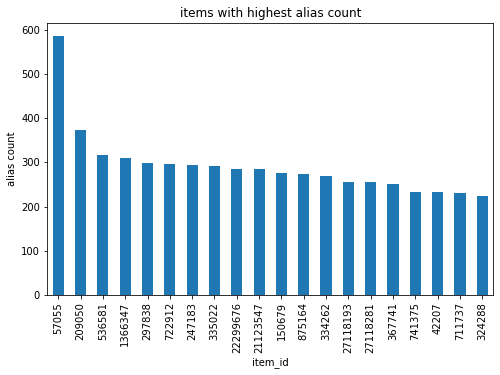

In [10]:
# fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax = item_alias_count_sorted[:20].plot.bar(figsize=(8,5), legend=False)
ax.set_title("items with highest alias count")
ax.set_ylabel("alias count")
plt.show()

In [11]:
#display item names
highest = list(df_item[df_item.item_id.isin(item_alias_count_sorted[:10].index)].en_label.compute())
print('highest ones: ',highest)

highest ones:  ['acetaminophen', 'Jan Brueghel the Elder', 'Cornelius van Poelenburgh', 'Jusepe de Ribera', 'David Teniers the Younger', 'Christian Wilhelm Ernst Dietrich', 'Willem van de Velde the Elder', 'Jacques Courtois', 'negative regulation of glucuronosyltransferase activity', 'positive regulation of glucuronosyltransferase activity']


In [12]:
df_item_aliases[df_item_aliases["item_id"] == item_alias_count_sorted.index[0]].compute().head()

,item_id,en_alias
61051,57055,Panadol®
61052,57055,Tylenol®
61053,57055,APAP
61054,57055,p-Acetylaminophenol
61055,57055,Acetaminofen


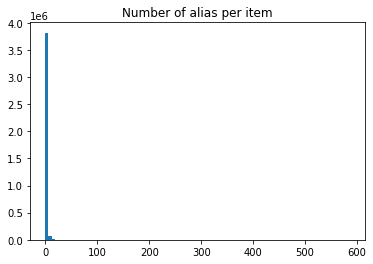

In [13]:
#histogram of #alias per item
plt.hist(item_alias_count.alias_count, bins = 100)
plt.title('Number of alias per item')
plt.show()

Most of them don't have any alias

In [14]:
property_alias_count = df_property_aliases.groupby('property_id').count().rename(columns={"en_alias": "alias_count"}).compute()
property_alias_count_sorted = property_alias_count[property_alias_count["alias_count"] > 1].sort_values(by=["alias_count"], ascending=False)
print(f"share of properties with two or more aliases: {round(property_alias_count_sorted.shape[0]/property_alias_count.shape[0], 4)}")

share of properties with two or more aliases: 0.5779


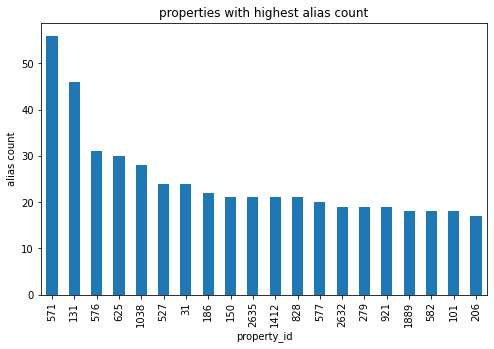

In [15]:
# fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax = property_alias_count_sorted[:20].plot.bar(figsize=(8,5), legend=False)
ax.set_title("properties with highest alias count")
ax.set_ylabel("alias count")
plt.show()

In [16]:
#display item names
highest2 = list(df_property[df_property.property_id.isin(property_alias_count_sorted[:10].index)].en_label.compute())
print('highest ones: ',highest2)    

highest ones:  ['instance of', 'located in the administrative territorial entity', 'contains administrative territorial entity', 'material used', 'has part', 'inception', 'dissolved, abolished or demolished', 'coordinate location', 'relative', 'number of parts of this work of art']


In [17]:
df_property_aliases[df_property_aliases["property_id"] == property_alias_count_sorted.index[0]].compute().head()

,property_id,en_alias
1586,571,date founded
1587,571,date created
1588,571,incorporated
1589,571,foundation
1590,571,created


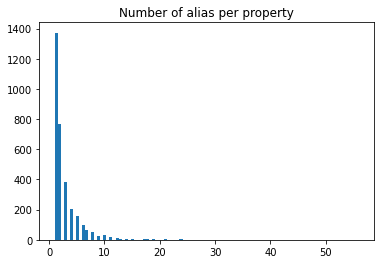

In [18]:
#histogram of #alias per item

plt.hist(property_alias_count.alias_count, bins = 100)
plt.title('Number of alias per property')
plt.show()

## Statement summary statistics

In [19]:
df_statements.head()

,source_item_id,edge_property_id,target_item_id
0,1,31,36906466
1,1,279,3695190
2,1,398,497745
3,1,398,1133705
4,1,398,1139177


In [20]:
# data frame for tabulating number of properties defined for each item
property_counts_per_item = df_statements[['source_item_id', 'edge_property_id']].groupby('source_item_id').count().rename(columns={"edge_property_id": "property_counts"}).compute()
property_counts_per_item.head()

,property_counts
source_item_id,
1,37
2,58
3,25
4,28
5,44


In [21]:
property_counts_per_item['property_counts'].describe(percentiles=[.25, .5, .75, 0.9, 0.95, 0.99])

count    5.110668e+07
mean     2.762982e+00
std      3.219263e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
90%      5.000000e+00
95%      7.000000e+00
99%      1.400000e+01
max      1.899000e+03
Name: property_counts, dtype: float64

In [22]:
property_counts_per_item[property_counts_per_item["property_counts"] >= 100]

,property_counts
source_item_id,
16,322
17,280
20,198
27,147
28,223
...,...
68534892,459
68900101,211
68994627,162


In [23]:
#display highest one and properties it has
#find the source_item_id with maximum property counts
max_id = list(property_counts_per_item[property_counts_per_item.property_counts==np.max(property_counts_per_item['property_counts'])].index)[0]
#find the label of the item corresponding to the id
label = df_item[df_item.item_id == max_id].en_label.compute()
print('Item with maximum number of properties is: {} with id {}'.format(label, max_id))
#find the edge_property_id's corresponding to this source_item_id
properties = list(df_statements[df_statements.source_item_id==max_id].edge_property_id.compute())
#find the labels of those edge_property_id's
properties = list(df_property[df_property.property_id.isin(properties)].en_label.compute())
print('Associated properties are: ', properties)

Item with maximum number of properties is: 813689    The Complete Encyclopedia of World Aircraft
Name: en_label, dtype: object with id 21014429
Associated properties are:  ['instance of', 'publisher', 'depicts', 'language of work or name']


In [24]:
num_items_by_property_counts = pd.DataFrame(property_counts_per_item['property_counts'].value_counts()).reset_index().rename(columns={"index": "property_counts", "property_counts": "num_items"})
num_items_by_property_counts

,property_counts,num_items
0,1,16323489
1,2,14406063
2,3,11243989
3,4,3444684
4,5,1628663
...,...,...
454,406,1
455,407,1
456,409,1
457,414,1


In [25]:
num_items_by_property_counts[["property_counts", "num_items"]]

,property_counts,num_items
0,1,16323489
1,2,14406063
2,3,11243989
3,4,3444684
4,5,1628663
...,...,...
454,406,1
455,407,1
456,409,1
457,414,1


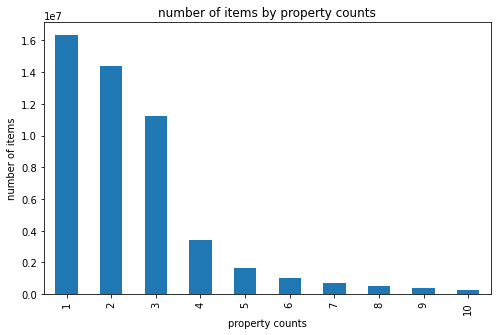

In [26]:
ax = num_items_by_property_counts[:10].plot.bar(x="property_counts", y="num_items", figsize=(8,5), legend=False)
ax.set_title("number of items by property counts")
ax.set_xlabel("property counts")
ax.set_ylabel("number of items")
plt.show()

Most items have a small number of properties defined (less than 3) but there is a long tail. 

In [2]:
#software to display kwg